In [1]:
""" ===================================================  Load Packages =================================================== """
import numpy as np
import geopandas as gpd
import pandas as pd
import math
from shapely.geometry import Point
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os


""" ============================================== Figure Settings ==================================================== """

rcParams['font.family'] = 'Times New Roman'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.default'] = 'regular'
rcParams['mathtext.cal'] = 'Arial'
rcParams['legend.fontsize'] = 'medium'


""" =================================================  Define Function ================================================ """

# define function from str to float
def strlist_coversion_array(string):
    aa = string.split(', ')
    aa[0] = aa[0].split('[')[1]
    aa[-1] = aa[-1].split(']')[0]
    return np.float_(aa)

## Graph Construction

def undirected_graph(zone_id_attribute, threshold, h_vector): # take lane direction into no consideration
    
    spatial_dependency = [[], [], []] # sparse matrix {node i, node j, value}
    distance_matrix = []
    for i in range (len(zone_id_attribute)):
        for j in range (len(zone_id_attribute)):
            # geographic distance
            geographic_distance = zone_id_attribute.iloc[i].geometry.distance(zone_id_attribute.iloc[j].geometry)
            if geographic_distance < threshold:
                spatial_dependency[0].append(zone_id_attribute.zone_id.iloc[i])
                spatial_dependency[1].append(zone_id_attribute.zone_id.iloc[j])
                spatial_dependency[2].append(math.exp(- h_vector * geographic_distance ** 2))
                distance_matrix.append(geographic_distance)
    return spatial_dependency, distance_matrix


def geo_direction(lat1, lon1, lat2, lon2):
    angle = math.atan2(math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(lon2-lon1), math.sin(lon2-lon1) * math.cos(lat2))
    bearing = math.degrees(angle)
    if bearing < 0:
        bearing = bearing + 360
    return bearing

def lane_direction(lane):
    if lane == 'East':
        bearing = 0
    elif lane == 'North':
        bearing = 90
    elif lane == 'West':
        bearing = 180
    else:
        bearing = 270
    return bearing
    
def directed_graph(zone_id_attribute, threshold, h_vector): # take lane direction into consideration
    
    spatial_dependency = [[], [], []] # sparse matrix {node i, node j, value}
    distance_matrix = []
    for i in range (len(zone_id_attribute)):
        for j in range (len(zone_id_attribute)):
            # Calculate geographical direction between two gps points
            bearing = geo_direction(zone_id_attribute.iloc[i].latitude, zone_id_attribute.iloc[i].longitude, zone_id_attribute.iloc[j].latitude, zone_id_attribute.iloc[j].longitude)
            #calculate land direction between two gps points
            theta1 = np.abs(lane_direction(zone_id_attribute.iloc[i].direction) - bearing)
            theta2 = np.abs(lane_direction(zone_id_attribute.iloc[j].direction) - bearing)
            if (theta1 < 90) and (theta2 < 90):
                theta = np.mean([theta1, theta2])
            
                # geographic distance
                geographic_distance = zone_id_attribute.iloc[i].geometry.distance(zone_id_attribute.iloc[j].geometry)
                distance_matrix.append(geographic_distance)
                spatial_dependency[0].append(zone_id_attribute.zone_id.iloc[i])
                spatial_dependency[1].append(zone_id_attribute.zone_id.iloc[j])
                spatial_dependency[2].append(math.exp(- h_vector * np.sin(theta) * geographic_distance ** 2))
    
    return spatial_dependency, distance_matrix

def graph_array_dataframe(data_list):
    dataframe = pd.DataFrame(np.array(data_list).T)
    dataframe = dataframe.rename(columns = {dataframe.columns[0]: 'o_zone_id'})
    dataframe = dataframe.rename(columns = {dataframe.columns[1]: 'd_zone_id'})
    dataframe = dataframe.rename(columns = {dataframe.columns[2]: 'dist'})
    return dataframe

In [2]:
""" =================================  Load Boundary, Network and land use Data =================================== """

# Miami-Dade boundary data
data_uniform_miami_boundary = gpd.read_file('Data/Miami-Dade_Boundary.geojson')

# Road network data within miami-dade county
data_uniform_miami_road_network = gpd.read_file('Data/Major_Road.geojson')

# Load zone_id_attribute in miami-dade county
data_uniform_attribute = pd.read_csv('Excel/zone_id_eff_dataframe.csv')
data_uniform_attribute = data_uniform_attribute.drop(columns = ['geometry'])
data_uniform_attribute['geometry'] = data_uniform_attribute[['longitude', 'latitude']].values.tolist()
data_uniform_attribute['geometry'] = data_uniform_attribute['geometry'].apply(Point)
data_uniform_attribute = gpd.GeoDataFrame(data_uniform_attribute)

# weather data
weather_data = pd.read_csv('Data/Miami_weather_2019-2020.csv') # daily weather/precipitation data
weather_data = weather_data.rename(columns={"COOPID": "measurement_start", " PRECIPITATION": "precipitation", " MAX TEMP": "max_temp", " MIN TEMP": "min_temp", " MEAN TEMP": "mean_temp"})
for i in range (len(weather_data)):
    weather_data['measurement_start'].iloc[i] = pd.to_datetime(str(weather_data[' YEAR'].iloc[i]) + '/' + str(weather_data[' MONTH'].iloc[i]) + '/' + str(weather_data[' DAY'].iloc[i]), format = '%Y/%m/%d').tz_localize('UTC')
weather_data = weather_data.drop(columns = [' YEAR', ' MONTH', ' DAY'])

# Network_Traffic_Data
miami_network_resilience = pd.read_csv('Excel/miami_network_performance.csv')
for i in range(len(miami_network_resilience)):
    miami_network_resilience.performance.iloc[i] = strlist_coversion_array(miami_network_resilience.performance.iloc[i])
split_df_miami = pd.DataFrame(miami_network_resilience['performance'].tolist())
split_df_miami.values[split_df_miami >= 10] = np.nan
split_df_miami.values[split_df_miami <= 0] = np.nan
miami_network_resilience_daily = pd.concat([miami_network_resilience, split_df_miami], axis=1)
for i in range(len(miami_network_resilience_daily)):
    miami_network_resilience_daily.performance.iloc[i] = np.mean(miami_network_resilience_daily.iloc[i][2:])
miami_network_resilience_daily = miami_network_resilience_daily[miami_network_resilience_daily.performance != 0]

# Integrate resilience and attribute into one matrix
miami_resilience_attribute = data_uniform_attribute.merge(miami_network_resilience_daily, how='left', on='zone_id')
miami_resilience_attribute = miami_resilience_attribute[~miami_resilience_attribute['performance'].isnull()]
miami_resilience_attribute.performance = miami_resilience_attribute.performance.astype('float64')


## Hurricane Dorian

# Dorian_Traffic_Data
miami_dorian_resilience = pd.read_csv('Excel/dorian_network_performance.csv')
for i in range(len(miami_dorian_resilience)):
    miami_dorian_resilience.performance.iloc[i] = strlist_coversion_array(miami_dorian_resilience.performance.iloc[i])
split_df_dorian = pd.DataFrame(miami_dorian_resilience['performance'].tolist())
split_df_dorian.values[split_df_dorian >= 10] = np.nan
split_df_dorian.values[split_df_dorian <= 0] = np.nan
miami_dorian_resilience_daily = pd.concat([miami_dorian_resilience, split_df_dorian], axis=1)
for i in range(len(miami_dorian_resilience_daily)):
    miami_dorian_resilience_daily.performance.iloc[i] = np.mean(miami_dorian_resilience_daily.iloc[i][2:])
miami_dorian_resilience_daily = miami_dorian_resilience_daily[miami_dorian_resilience_daily.performance != 0]  


dorian_resilience_attribute = data_uniform_attribute.merge(miami_dorian_resilience_daily, how='left', on='zone_id')
dorian_resilience_attribute = dorian_resilience_attribute[~dorian_resilience_attribute['performance'].isnull()]
dorian_resilience_attribute.performance = dorian_resilience_attribute.performance.astype('float64')

D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:>

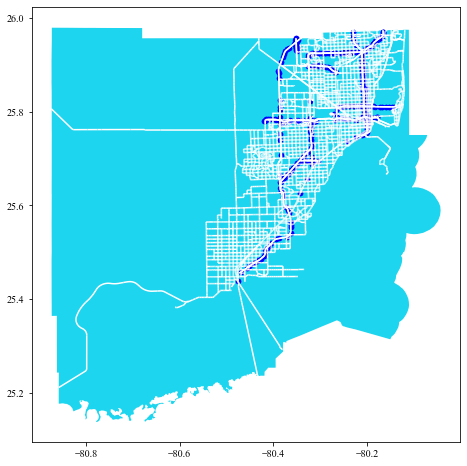

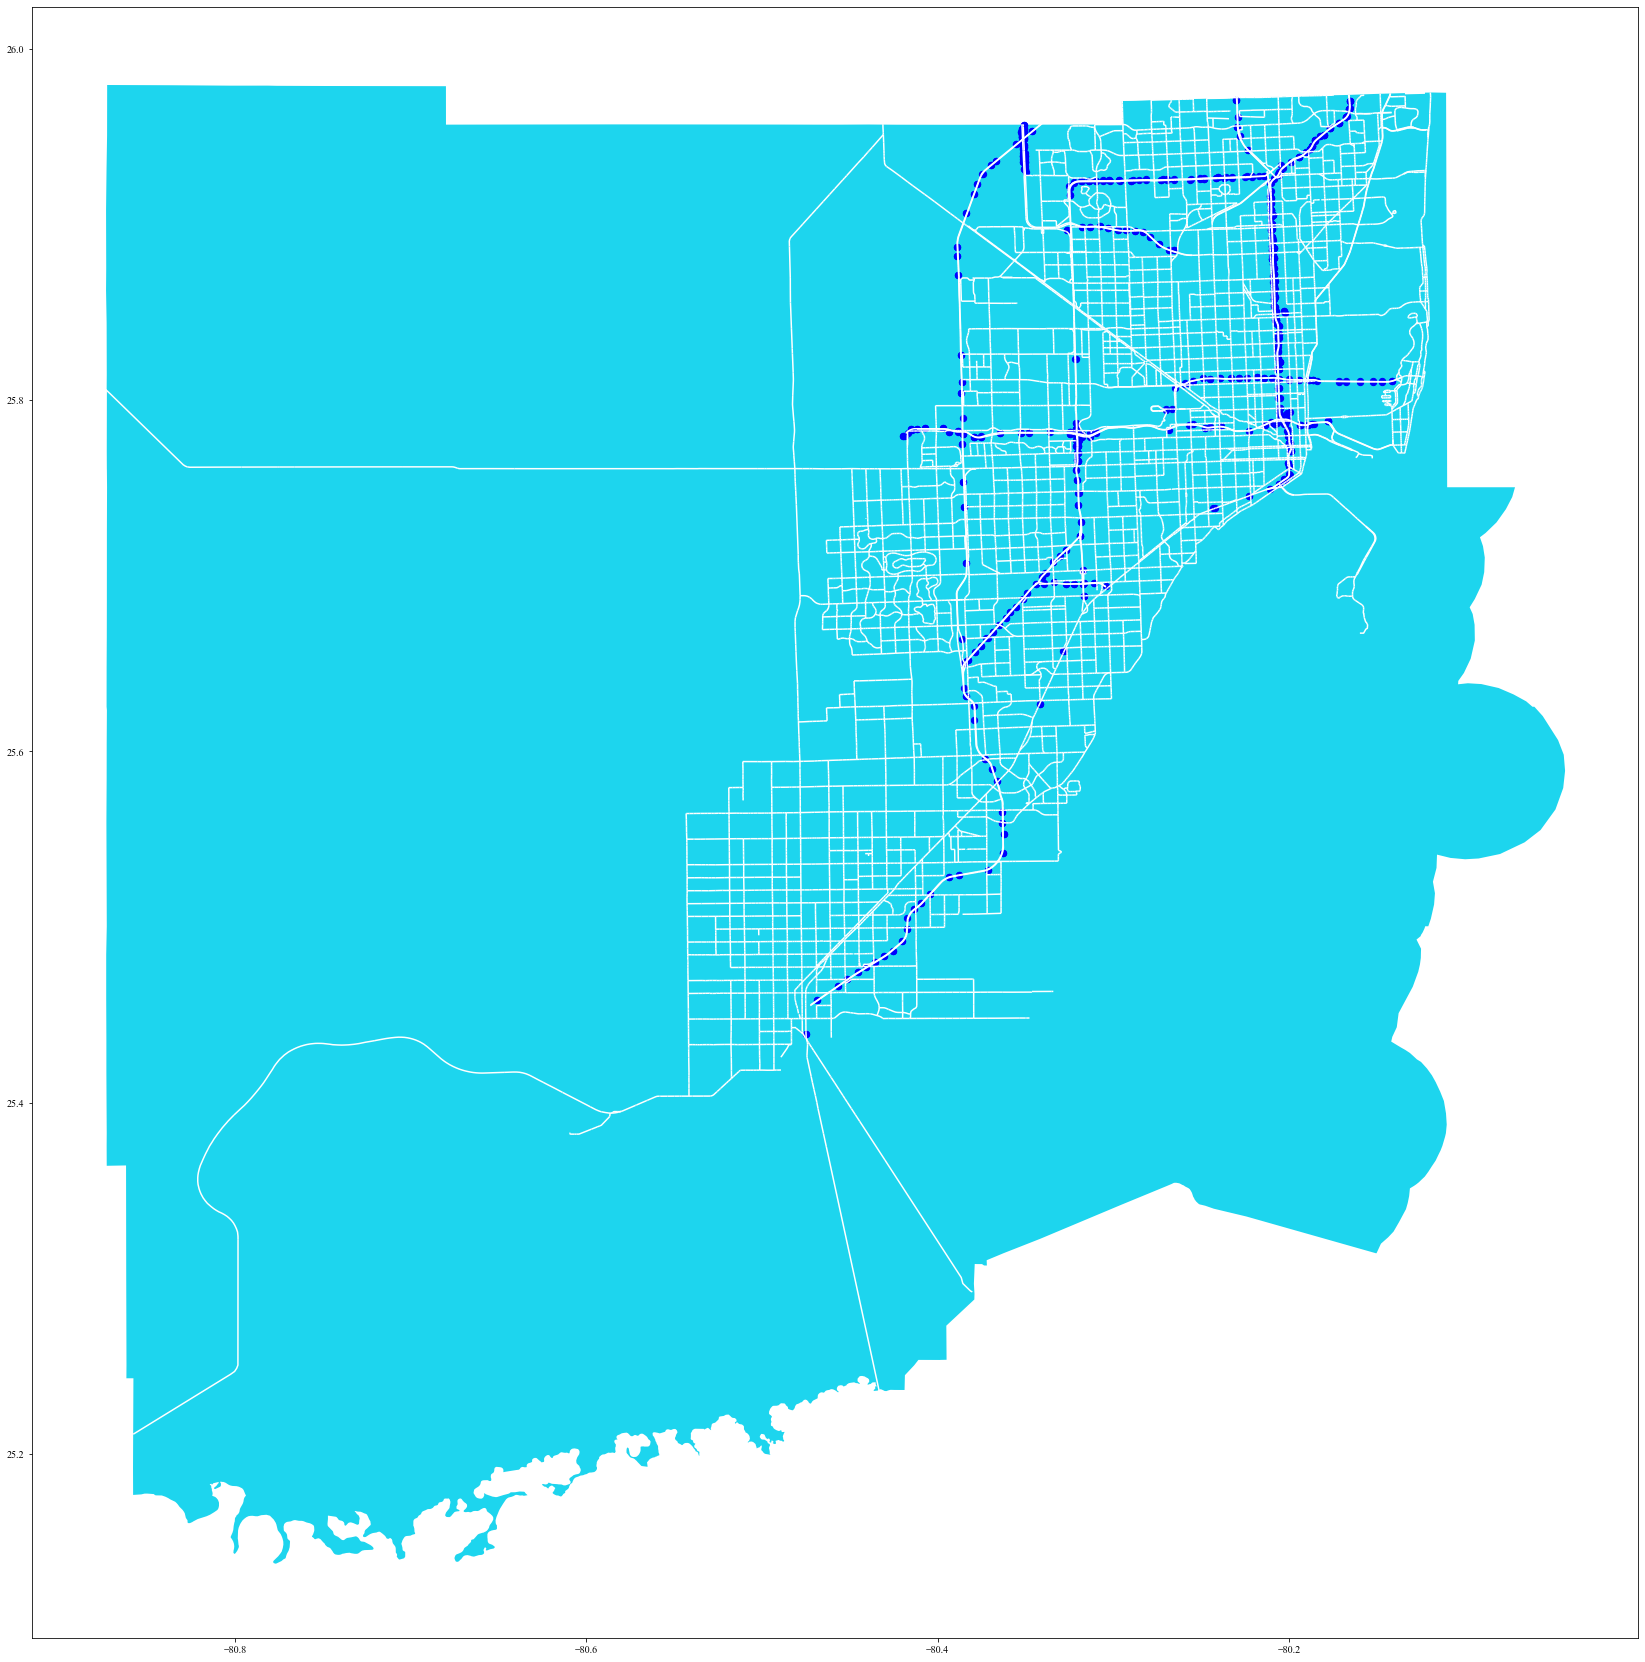

In [13]:
fig, ax = plt.subplots(1, figsize=(8,8))
divider = make_axes_locatable(ax)
base1 = data_uniform_miami_boundary.plot(ax=ax, color='#1DD5EE') # plot base map 1
base2 = data_uniform_miami_road_network.plot(ax=base1, color='#FFFFFF')
miami_resilience_attribute.plot(ax=base2, markersize=20, color='blue') # Plot

fig, ax = plt.subplots(1, figsize=(30,30))
divider = make_axes_locatable(ax)
base1 = data_uniform_miami_boundary.plot(ax=ax, color='#1DD5EE') # plot base map 1
base2 = data_uniform_miami_road_network.plot(ax=base1, color='#FFFFFF')
miami_resilience_attribute.plot(ax=base2, markersize=40, color='blue') # Plot

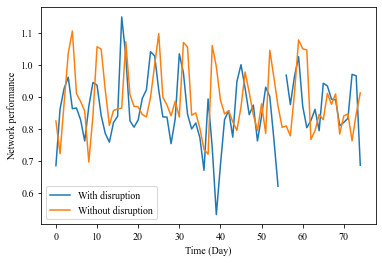

In [3]:
# Temporal Variations
plt.plot(dorian_resilience_attribute.iloc[0, -75:].to_numpy())
plt.plot(miami_resilience_attribute.iloc[0, 100:175].to_numpy())
plt.xlabel('Time (Day)')
plt.ylabel('Network performance')
plt.legend(['With disruption', 'Without disruption'])

D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<AxesSubplot:>

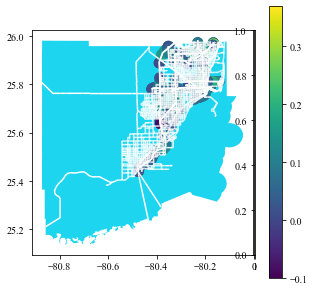

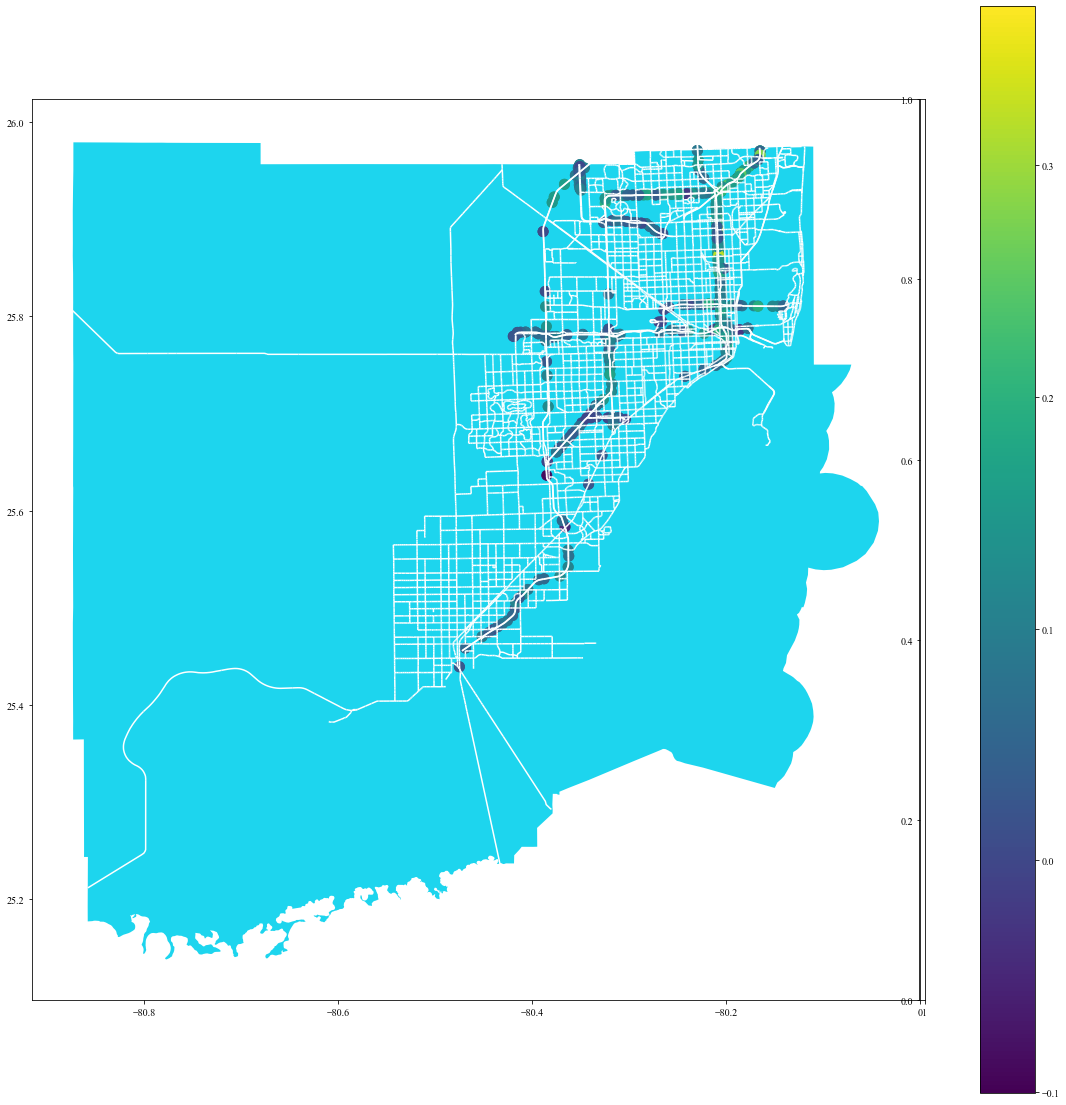

In [4]:
# Spatial distributions of network resilience from 2019-08-30 to 2019-09-05

network_resilience_data_miami = miami_resilience_attribute[['zone_id', 'latitude', 'longitude', 'geometry', 'performance']]
network_resilience_data_miami['resilience'] = np.mean(miami_resilience_attribute.iloc[:, -118:-111].to_numpy(), axis = 1) - np.mean(miami_resilience_attribute.iloc[:, -125:-118].to_numpy(), axis = 1)

fig, ax = plt.subplots(1, figsize=(5,5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="0.5%", pad=0.01)
base1 = data_uniform_miami_boundary.plot(ax=ax, color='#1DD5EE') # plot base map 1
base2 = data_uniform_miami_road_network.plot(ax=base1, color='#FFFFFF')
network_resilience_data_miami.plot(column='resilience', ax=base2, markersize=100, legend=True) # Plot


fig, ax = plt.subplots(1, figsize=(20,20))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="0.5%", pad=0.01)
base1 = data_uniform_miami_boundary.plot(ax=ax, color='#1DD5EE') # plot base map 1
base2 = data_uniform_miami_road_network.plot(ax=base1, color='#FFFFFF')
network_resilience_data_miami.plot(column='resilience', ax=base2, markersize=100, legend=True) # Plot

In [5]:
""" =================================  Data Preprocessing =================================== """

# Impute missing data

from sklearn.impute import SimpleImputer

df_miami = miami_resilience_attribute.drop(columns = ['lane_type', 'latitude', 'longitude', 'DESCR', 'state', 'road', 'direction', 'length', 'LU', 'TRACTCE10', 'geometry']).set_index('zone_id')
imputer = SimpleImputer(missing_values = np.nan, strategy='mean')
columns = ['dist_thre01', 'POPDENSITY']
imputer = imputer.fit(df_miami[columns])
df_miami[columns] = imputer.transform(df_miami[columns])

# 0-364
imputer = imputer.fit(df_miami.iloc[:, 3:])
df_miami.iloc[:, 3:] = imputer.transform(df_miami.iloc[:, 3:])


# Normalization of POPDENSITY: Add one new column "popdensity for df_miami"
from sklearn.preprocessing import MinMaxScaler

X = np.array(df_miami['POPDENSITY']).reshape(-1,1)
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
df_miami['popdensity'] = X_scaled.reshape(1,-1)[0]

In [6]:
""" ================================= Extract Spatial Features and Graph Construction =================================== """

# define distance threshold
threshold = 0.005 # threshold vector for 3 graphs: geographic distance, land use similarity, normalized demographics similarity
h_vector1 = 0.5 # gaussian kernel for 3 graphs: geographic distance, land use similarity, demographics similarity
h_vector2 = 0.5

data_uniform_attribute_miami = miami_resilience_attribute[['zone_id', 'state']].merge(data_uniform_attribute, how='left', on='zone_id')
zone_id_list = data_uniform_attribute_miami['zone_id'] # store the original label of zone id

# change the zone_id from specific number to 0-1158 coding
data_uniform_attribute_coding = data_uniform_attribute_miami.drop(columns = ['zone_id'])
data_uniform_attribute_coding['zone_id'] = np.arange(len(data_uniform_attribute_coding))
# Normalize the population density by column
data_uniform_attribute_coding['POPDENSITY'] = (data_uniform_attribute_coding['POPDENSITY'] - data_uniform_attribute_coding['POPDENSITY'].min()) / (data_uniform_attribute_coding['POPDENSITY'].max() - data_uniform_attribute_coding['POPDENSITY'].min())


# construct directed and undirected graphs
undirected_spatial_dependency, undirected_distance_array = undirected_graph(data_uniform_attribute_coding, threshold, h_vector1)
directed_spatial_dependency, directed_distance_array = directed_graph(data_uniform_attribute_coding, threshold, h_vector2)

GA_undirected = graph_array_dataframe(undirected_spatial_dependency)
GA_directed = graph_array_dataframe(directed_spatial_dependency)

In [7]:
## =========================================== Load Performance Dataset ========================================##
# extract the whole data set from csv file 
traffic_detector_data = pd.read_csv('Excel/miami_traffic_data_1920.csv')
traffic_data_time_performance = pd.DataFrame()
traffic_data_time_performance['time'] = traffic_detector_data['measurement_start'].unique()
for i in range (len(zone_id_list)):
    zone_id_traffic_data = pd.DataFrame()
    zone_id_traffic_data[str(zone_id_list[i])] = traffic_detector_data[traffic_detector_data['zone_id'] == zone_id_list[i]].performance.values
    traffic_data_time_performance = pd.concat([traffic_data_time_performance, zone_id_traffic_data], axis = 1)
    
# imputer
traffic_data_time_performance = traffic_data_time_performance.set_index('time')
imputer = SimpleImputer(missing_values = np.nan, strategy='mean')
imputer = imputer.fit(traffic_data_time_performance.iloc[:, 0:len(zone_id_list)])
traffic_data_time_performance.iloc[:, 0:len(zone_id_list)] = imputer.transform(traffic_data_time_performance.iloc[:, 0:len(zone_id_list)])
traffic_data_time_performance.head()

,8715,8726,8727,8728,8747,8844,8845,8947,8965,8989,...,14704,14705,14706,14707,14708,14709,14744,14745,14746,14747
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 05:00:00+00:00,0.667985,0.240873,0.338579,0.265263,0.591690,0.365718,0.376984,0.510778,0.452182,0.650960,...,0.139004,0.405596,0.249142,0.149091,0.283488,0.241290,0.275359,0.617351,0.320107,0.182649
2019-01-01 05:05:00+00:00,0.632623,0.171111,0.259364,0.216694,0.506696,0.414697,0.354909,0.510778,0.368035,0.628794,...,0.162857,0.405596,0.217794,0.182727,0.283488,0.154286,0.321120,0.649703,0.265298,0.200986
2019-01-01 05:10:00+00:00,0.711393,0.174000,0.242727,0.158132,0.603581,0.589090,0.580857,0.345262,0.359818,0.731804,...,0.139004,0.405596,0.216648,0.191591,0.283488,0.241290,0.358355,0.651569,0.247236,0.196567
2019-01-01 05:15:00+00:00,0.869444,0.177121,0.228651,0.165669,0.695702,0.840148,0.694571,0.125455,0.456773,0.913862,...,0.139004,0.405596,0.278425,0.191364,0.283488,0.241290,0.361088,0.870248,0.269333,0.245897
2019-01-01 05:20:00+00:00,0.947264,0.162893,0.309000,0.134538,0.868125,0.900154,0.981143,0.510778,0.531775,1.027198,...,0.154286,0.405596,0.352634,0.266579,0.283488,0.152143,0.460677,1.126386,0.330388,0.227152


In [8]:
## ========================== Split Dataset into Training, Validation, and Testing Set =========================##
traffic_data_model = traffic_data_time_performance.to_numpy()


# Store data into each partition
training_dataset = traffic_data_model[0:int(len(traffic_data_model)*0.1)]
validation_dataset = traffic_data_model[int(len(traffic_data_model)*0.1):int(len(traffic_data_model)*0.11)]
testing_dataset = traffic_data_model[int(len(traffic_data_model)*0.11):int(len(traffic_data_model)*0.12)]


# Initiaton value of lag
lag = 12
# sliding windows function
def create_sliding_windows(data,len_data,lag):
    x=[]
    y=[]
    for i in range(lag,len_data):
        x.append(data[i-lag:i])
        y.append(data[i]) 
    return np.array(x),np.array(y)

# Create sliding windows into training data
X_train, Y_train = create_sliding_windows(training_dataset, len(training_dataset), lag)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],738))
# Create sliding windows into validation data
X_val,Y_val = create_sliding_windows(validation_dataset,len(validation_dataset),lag)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],738))
# Create sliding windows into test data
X_test, Y_test = create_sliding_windows(testing_dataset,len(testing_dataset),lag)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],738))

# Above dataset for GRCRNN Model
# Below dataset for machine learning models, GRU and LSTM Models

# Initiaton value of lag
lag = 12
# sliding windows function
def create_sliding_windows1(data,len_data,lag):
    x=[]
    y=[]
    for i in range(lag,len_data):
        x.append(data[i-lag:i])
        y.append(data[i]) 
    return np.array(x),np.array(y)

# Create sliding windows into training data
x_train, y_train = create_sliding_windows1(training_dataset[:, 0], len(training_dataset[:, 0]), lag)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
# Create sliding windows into validation data
x_val,y_val = create_sliding_windows1(validation_dataset[:, 0],len(validation_dataset[:, 0]),lag)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1],1))
# Create sliding windows into test data
x_test, y_test = create_sliding_windows1(testing_dataset[:, 0],len(testing_dataset[:, 0]),lag)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))



In [9]:
## ======================================= SVR Model ========================================== ##

Result Mean Absolute Error Prediction Model :  0.0652
Result Root Mean Square Error Prediction Model : 0.1024
Result Correlation Coefficient Prediction Model : 0.9579


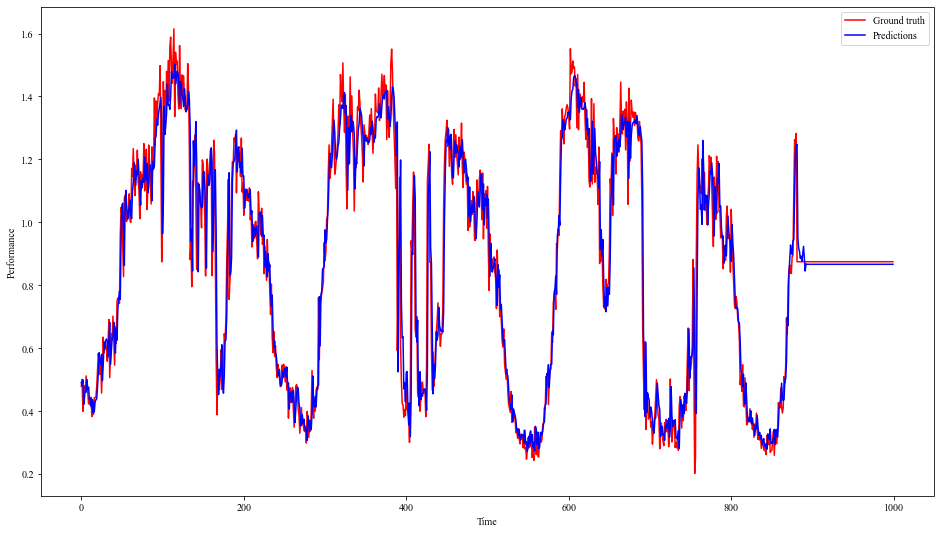

In [10]:
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

np.random.seed(21)

svr = SVR().fit(x_train.reshape((x_train.shape[0], x_train.shape[1])), y_train)

y_pred_test_SVR = svr.predict(x_test.reshape((x_test.shape[0], x_test.shape[1])))

# Calculatre value of Root Mean Square Error
def mae(datatest, datapred): 
    return np.round(np.mean(np.abs(datatest - datapred)), 4)
print('Result Mean Absolute Error Prediction Model : ', mae(y_test, y_pred_test_SVR.reshape(1,-1)))

def rmse(datatest, datapred):
    return np.round(np.sqrt(np.mean((datatest - datapred) ** 2)), 4)
print('Result Root Mean Square Error Prediction Model :', rmse(y_test, y_pred_test_SVR.reshape(1,-1)))

def coef(datatest, datapred):
    return np.round((np.corrcoef(datapred, datatest)[0,1]), 4)
print('Result Correlation Coefficient Prediction Model :', coef(y_test, y_pred_test_SVR.reshape(1,-1)))

# Create graph data test and prediction result
fig = plt.figure(figsize = (16, 9))
plt.plot(y_test[0:1000], color='red',label='Ground truth')
plt.plot(y_pred_test_SVR[0:1000], color='blue',label='Predictions')
plt.xlabel('Time')
plt.ylabel('Performance')
plt.legend()
plt.show()

In [11]:
## ======================================= RF Model ========================================== ##

Result Mean Absolute Error Prediction Model :  0.0702
Result Root Mean Square Error Prediction Model : 0.1082
Result Correlation Coefficient Prediction Model : 0.9529


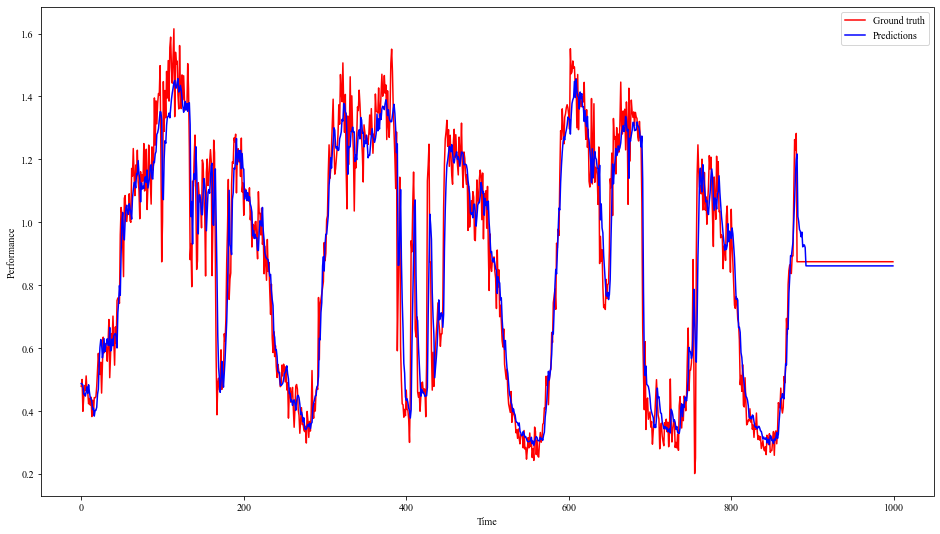

In [12]:
from sklearn.ensemble._forest import RandomForestRegressor

# build our RF model
RF_Model = RandomForestRegressor(n_estimators=100,
                                 max_features=1, oob_score=True)
# let's get the labels and features in order to run our 

rgr=RF_Model.fit(x_train.reshape((x_train.shape[0], x_train.shape[1])), y_train)

y_pred_test_RF = rgr.predict(x_test.reshape((x_test.shape[0], x_test.shape[1])))

# Calculatre value of Root Mean Square Error
def mae(datatest, datapred): 
    return np.round(np.mean(np.abs(datatest - datapred)), 4)
print('Result Mean Absolute Error Prediction Model : ', mae(y_test, y_pred_test_RF.reshape(1,-1)))

def rmse(datatest, datapred):
    return np.round(np.sqrt(np.mean((datatest - datapred) ** 2)), 4)
print('Result Root Mean Square Error Prediction Model :', rmse(y_test, y_pred_test_RF.reshape(1,-1)))

def coef(datatest, datapred):
    return np.round((np.corrcoef(datapred, datatest)[0,1]), 4)
print('Result Correlation Coefficient Prediction Model :', coef(y_test, y_pred_test_RF.reshape(1,-1)))

# Create graph data test and prediction result
fig = plt.figure(figsize = (16, 9))
plt.plot(y_test[0:1000], color='red',label='Ground truth')
plt.plot(y_pred_test_RF[0:1000], color='blue',label='Predictions')
plt.xlabel('Time')
plt.ylabel('Performance')
plt.legend()
plt.show()

In [13]:
## ======================================= GRU Model ========================================== ##

In [14]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout,GRU

# Hyperparameters
learning_rate = 0.0001
hidden_unit = 64
batch_size=256
epoch = 100

# Architecture Gated Recurrent Unit
regressorGRU = Sequential()

# First GRU layer with dropout
regressorGRU.add(GRU(units=hidden_unit, return_sequences=True, input_shape=(x_train.shape[1],1), activation = 'tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer with dropout
regressorGRU.add(GRU(units=hidden_unit, return_sequences=True, activation = 'tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer with dropout
regressorGRU.add(GRU(units=hidden_unit, return_sequences=False, activation = 'tanh'))
regressorGRU.add(Dropout(0.2))

# Output layer
regressorGRU.add(Dense(units=1))

# Compiling the Gated Recurrent Unit
regressorGRU.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),loss='mean_squared_error')

# Fitting ke data training dan data validation
pred_GRU = regressorGRU.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=batch_size, epochs=epoch)

Epoch 1/100


D:\Software\Anaconda\Install\envs\gpd_env\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


42/42 [==============================] - 6s 43ms/step - loss: 0.5489 - val_loss: 0.1083
Epoch 2/100
42/42 [==============================] - 1s 23ms/step - loss: 0.0620 - val_loss: 0.0370
Epoch 3/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0446 - val_loss: 0.0344
Epoch 4/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0428 - val_loss: 0.0318
Epoch 5/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0413 - val_loss: 0.0305
Epoch 6/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0393 - val_loss: 0.0294
Epoch 7/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0376 - val_loss: 0.0278
Epoch 8/100
42/42 [==============================] - 1s 21ms/step - loss: 0.0367 - val_loss: 0.0264
Epoch 9/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0352 - val_loss: 0.0255
Epoch 10/100
42/42 [==============================] - 1s 20ms/step - loss: 0.0352 - val_loss: 0.0248
Epoch 11/10

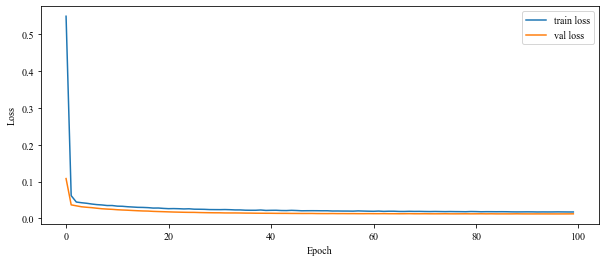

In [29]:
# Graph model loss (train loss & val loss)
fig = plt.figure(figsize=(10, 4))
plt.plot(pred_GRU.history['loss'], label='train loss')
plt.plot(pred_GRU.history['val_loss'], label='val loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

Result Mean Absolute Error Prediction Model :  0.0694
Result Root Mean Square Error Prediction Model : 0.105
Result Correlation Coefficient Prediction Model : 0.9564


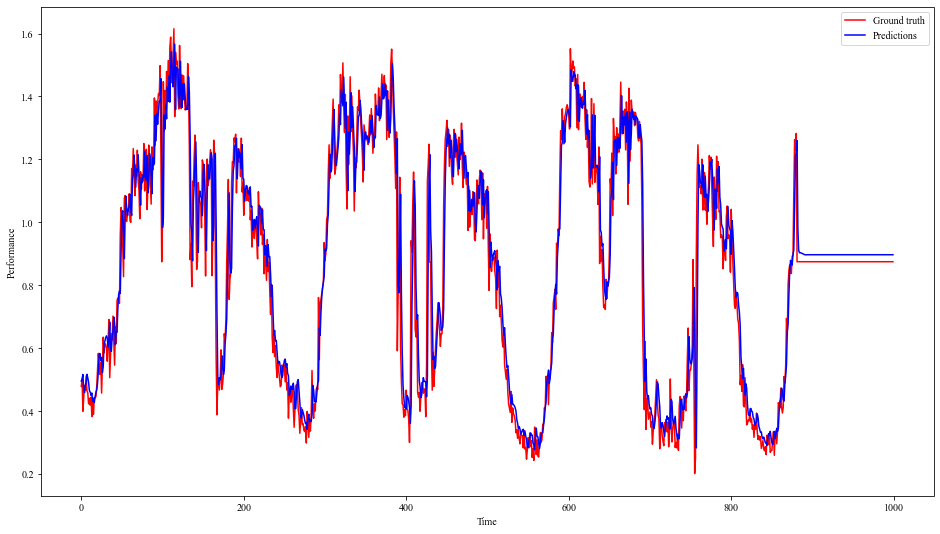

In [16]:
# testing set

# Implementation model into data test
y_pred_test_GRU = regressorGRU.predict(x_test)

# Calculatre value of Root Mean Square Error
def mae(datatest, datapred): 
    return np.round(np.mean(np.abs(datatest - datapred)), 4)
print('Result Mean Absolute Error Prediction Model : ', mae(y_test, y_pred_test_GRU.reshape(1,-1)))

def rmse(datatest, datapred):
    return np.round(np.sqrt(np.mean((datatest - datapred) ** 2)), 4)
print('Result Root Mean Square Error Prediction Model :', rmse(y_test, y_pred_test_GRU.reshape(1,-1)))

def coef(datatest, datapred):
    return np.round((np.corrcoef(datapred, datatest)[0,1]), 4)
print('Result Correlation Coefficient Prediction Model :', coef(y_test, y_pred_test_GRU.reshape(1,-1)))

# Create graph data test and prediction result
fig = plt.figure(figsize = (16, 9))
plt.plot(y_test[0:1000], color='red',label='Ground truth')
plt.plot(y_pred_test_GRU[0:1000], color='blue',label='Predictions')
plt.xlabel('Time')
plt.ylabel('Performance')
plt.legend()
plt.show()

In [17]:
## ======================================= LSTM Model ========================================== ##

In [18]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix

numpy.random.seed(7)

# create and fit the LSTM network
lstm_model = Sequential()
lstm_model.add(LSTM(4, input_shape=(lag, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
ored_LSTM = lstm_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=256, verbose=2)

Epoch 1/100
42/42 - 2s - loss: 0.3548 - val_loss: 0.1217 - 2s/epoch - 44ms/step
Epoch 2/100
42/42 - 0s - loss: 0.1175 - val_loss: 0.0744 - 117ms/epoch - 3ms/step
Epoch 3/100
42/42 - 0s - loss: 0.0770 - val_loss: 0.0583 - 116ms/epoch - 3ms/step
Epoch 4/100
42/42 - 0s - loss: 0.0579 - val_loss: 0.0438 - 101ms/epoch - 2ms/step
Epoch 5/100
42/42 - 0s - loss: 0.0447 - val_loss: 0.0351 - 110ms/epoch - 3ms/step
Epoch 6/100
42/42 - 0s - loss: 0.0365 - val_loss: 0.0302 - 94ms/epoch - 2ms/step
Epoch 7/100
42/42 - 0s - loss: 0.0320 - val_loss: 0.0280 - 93ms/epoch - 2ms/step
Epoch 8/100
42/42 - 0s - loss: 0.0295 - val_loss: 0.0268 - 104ms/epoch - 2ms/step
Epoch 9/100
42/42 - 0s - loss: 0.0281 - val_loss: 0.0262 - 111ms/epoch - 3ms/step
Epoch 10/100
42/42 - 0s - loss: 0.0270 - val_loss: 0.0255 - 109ms/epoch - 3ms/step
Epoch 11/100
42/42 - 0s - loss: 0.0261 - val_loss: 0.0248 - 95ms/epoch - 2ms/step
Epoch 12/100
42/42 - 0s - loss: 0.0253 - val_loss: 0.0240 - 116ms/epoch - 3ms/step
Epoch 13/100
42/42

42/42 - 0s - loss: 0.0123 - val_loss: 0.0120 - 99ms/epoch - 2ms/step


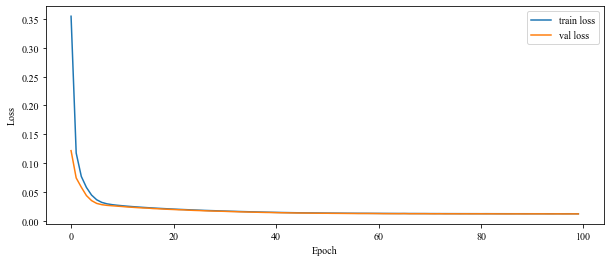

In [30]:
# Graph model loss (train loss & val loss)
fig = plt.figure(figsize=(10, 4))
plt.plot(ored_LSTM.history['loss'], label='train loss')
plt.plot(ored_LSTM.history['val_loss'], label='val loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

Result Mean Absolute Error Prediction Model :  0.0641
Result Root Mean Square Error Prediction Model : 0.1021
Result Correlation Coefficient Prediction Model : 0.9582


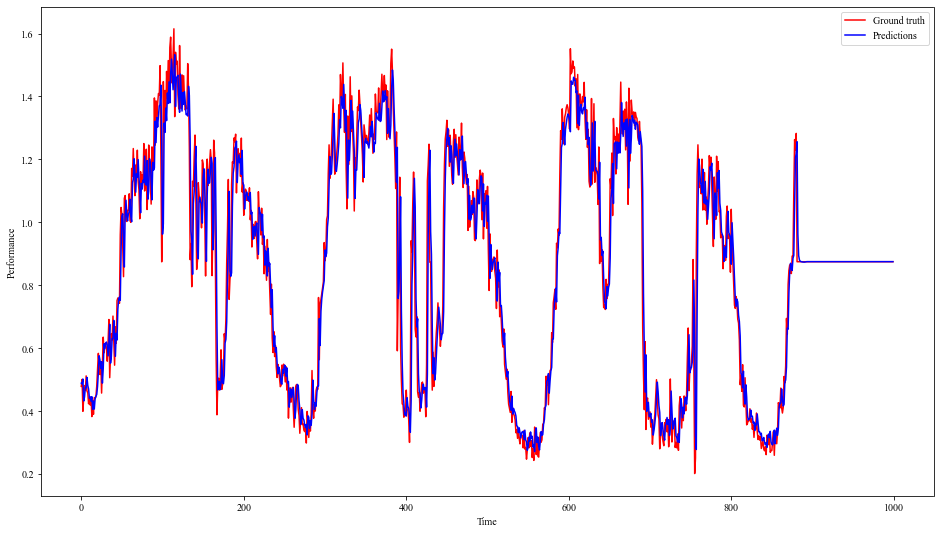

In [20]:
# make predictions
y_pred_test_LSTM = lstm_model.predict(x_test)

def mae(datatest, datapred): 
    return np.round(np.mean(np.abs(datatest - datapred)), 4)
print('Result Mean Absolute Error Prediction Model : ', mae(y_test, y_pred_test_LSTM.reshape(1,-1)))

def rmse(datatest, datapred):
    return np.round(np.sqrt(np.mean((datatest - datapred) ** 2)), 4)
print('Result Root Mean Square Error Prediction Model :', rmse(y_test, y_pred_test_LSTM.reshape(1,-1)))

def coef(datatest, datapred):
    return np.round((np.corrcoef(datapred, datatest)[0,1]), 4)
print('Result Correlation Coefficient Prediction Model :', coef(y_test, y_pred_test_LSTM.reshape(1,-1)))

# Create graph data test and prediction result
fig = plt.figure(figsize = (16, 9))
plt.plot(y_test[0:1000], color='red',label='Ground truth')
plt.plot(y_pred_test_LSTM[0:1000], color='blue',label='Predictions')
plt.xlabel('Time')
plt.ylabel('Performance')
plt.legend()
plt.show()

In [21]:
## ======================================= Undirected GDCRNN Model ========================================== ##

In [22]:
import dgl
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import numpy as np
import networkx as nx
import scipy.sparse as sps
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

# calculate the number of nodes in a graph
node_count = len(df_miami)

# construct a graph
def build_graph(edges):
    g = dgl.DGLGraph()
    g.add_nodes(node_count)
    g.add_edges(edges[:,0].astype(int), edges[:,1].astype(int))
    return g

GA_undirected_graph = build_graph(GA_undirected.iloc[:,0:2].to_numpy())

# construct adjacent matrix
def graph_matrix(dataframe):
    data_matrix = np.zeros((node_count,node_count))
    for i in range (len(dataframe)):
        data_matrix[int(dataframe.iloc[i, 0]), int(dataframe.iloc[i, 1])] = dataframe.iloc[i, 2]
    data_matrix = data_matrix.astype(np.float32)
    return data_matrix

# adjacent matrix
GA_undirected_processed = graph_matrix(GA_undirected)

# Take GA_undirected_graph as an example, to add attribute 'popdensity' and 'dist_thre01' as feature vector of each node
graph = GA_undirected_graph
graph = graph.to_networkx()
node_attrs = {i: list(torch.from_numpy(df_miami[['dist_thre01', 'popdensity']].to_numpy())) for i in np.arange(graph.number_of_nodes())}
nx.set_node_attributes(graph, node_attrs, 'name')

Using backend: pytorch
C:\Users\Kaifa Lu\AppData\Roaming\Python\Python39\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


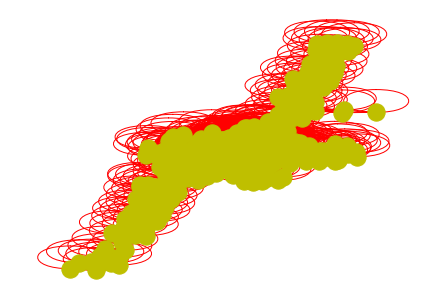

In [23]:
# Visualization of Node Connections Within Highway Network

nx_GA_undirected_graph = GA_undirected_graph.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_GA_undirected_graph)
nx.draw(nx_GA_undirected_graph, pos, with_labels=False, node_color = 'y', edge_color = 'r')

In [24]:
## ======================================= Directed GDCRNN Model ========================================== ##

In [25]:
## ============================================== GCN for Graph construction =============================== ##
import dgl
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import numpy as np
import networkx as nx
import scipy.sparse as sps
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

# calculate the number of nodes in a graph
node_count = len(df_miami)

# construct a graph
def build_graph(edges):
    g = dgl.DGLGraph()
    g.add_nodes(node_count)
    g.add_edges(edges[:,0].astype(int), edges[:,1].astype(int))
    return g

GA_directed_graph = build_graph(GA_directed.iloc[:,0:2].to_numpy())

# construct adjacent matrix
def graph_matrix(dataframe):
    data_matrix = np.zeros((node_count,node_count))
    for i in range (len(dataframe)):
        data_matrix[int(dataframe.iloc[i, 0]), int(dataframe.iloc[i, 1])] = dataframe.iloc[i, 2]
    data_matrix = data_matrix.astype(np.float32)
    return data_matrix

# adjacent matrix
GA_directed_processed = graph_matrix(GA_directed)

# Take GA_undirected_graph as an example, to add attribute 'popdensity' and 'dist_thre01' as feature vector of each node
graph = GA_directed_graph
graph = graph.to_networkx()
# node_attrs = {i: list(torch.from_numpy(df_miami[['dist_thre01', 'popdensity']].to_numpy())) for i in np.arange(graph.number_of_nodes())}
# nx.set_node_attributes(graph, node_attrs, 'name')

C:\Users\Kaifa Lu\AppData\Roaming\Python\Python39\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


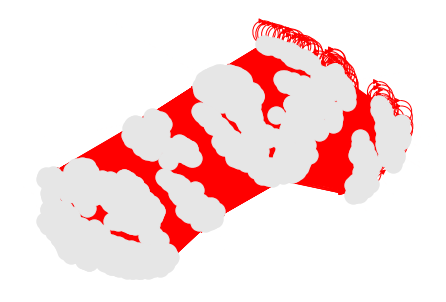

In [26]:
# Visualization of Node Connections Within Highway Network

nx_GA_directed_graph = GA_directed_graph.to_networkx().to_directed()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_GA_directed_graph)
nx.draw(nx_GA_directed_graph, pos, with_labels=False, node_color=[[.9, .9, .9]], edge_color = 'r')